# Underwater Image Enhancement Project

This Jupyter Notebook contains the complete Python implementation of the underwater image restoration algorithm based on the paper *"Underwater Image Restoration via Constrained Color Compensation and Background Light Color Space-based Haze-Line Model"*.

The code is organized into the following cells:
1. **Dependencies**: Imports all required libraries.
2. **Helper Functions**: The Python translations of `Grayscale_remapping`, `estimate_airlight`, and `wls_optimization`.
3. **Core Algorithm**: The main `CCCBLSHL` function.
4. **Main Execution Pipeline**: The `main` function that loads images from an `image` folder and processes them using a full enhancement pipeline (Restoration -> White Balance -> Saturation -> Contrast).

In [1]:
# Cell 1: Dependencies & Imports
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.signal import convolve2d
from scipy.sparse import spdiags
from scipy.sparse.linalg import spsolve
from skimage.color import rgb2lab, lab2rgb
from skimage.exposure import rescale_intensity
from skimage.segmentation import slic
from sklearn.cluster import KMeans

## Cell 2: Helper Functions

In [2]:
# Grayscale_remapping.py
def Grayscale_remapping(image):
    image_float = image.astype(np.float64)
    V = np.max(image_float, axis=(0, 1))
    max_1 = np.max(V)
    ratio = np.array([1, 1, 1])
    satLevel = 0.001 * ratio
    m, n, p = image_float.shape
    imgRGB_orig = np.zeros((p, m * n), dtype=np.float64)
    for i in range(p):
       imgRGB_orig[i, :] = image_float[:, :, i].flatten()
    imRGB = np.zeros_like(imgRGB_orig)
    for ch in range(p):
        q = np.array([satLevel[ch], 1 - satLevel[ch]])
        tiles = np.quantile(imgRGB_orig[ch, :], q)
        temp = imgRGB_orig[ch, :].copy()
        temp[temp < tiles[0]] = tiles[0]
        temp[temp > tiles[1]] = tiles[1]
        imRGB[ch, :] = temp
        pmin = np.min(imRGB[ch, :])
        pmax = np.max(imRGB[ch, :])
        imRGB[ch, :] = (imRGB[ch, :] - pmin) / (pmax - pmin) * max_1
    output = np.zeros_like(image_float)
    for i in range(p):
        output[:, :, i] = imRGB[i, :].reshape(m, n)
    return output

In [3]:
# estimate_airlight.py
def _rgb2ind_python(img, n_colors):
    pixels = img.reshape(-1, 3)
    unique_colors, counts = np.unique(pixels, axis=0, return_counts=True)
    boxes = [{
        'colors': unique_colors,
        'counts': counts,
        'box': np.array([np.min(unique_colors, axis=0), np.max(unique_colors, axis=0)])
    }]
    while len(boxes) < n_colors:
        max_var, box_to_split_idx, split_axis = -1, -1, -1
        for i, box in enumerate(boxes):
            if box['colors'].shape[0] > 1:
                box_dims = box['box'][1] - box['box'][0]
                axis = np.argmax(box_dims)
                if box_dims[axis] > max_var:
                    max_var, box_to_split_idx, split_axis = box_dims[axis], i, axis
        if box_to_split_idx == -1: break
        box_to_split = boxes.pop(box_to_split_idx)
        colors_in_box, counts_in_box = box_to_split['colors'], box_to_split['counts']
        sorted_indices = np.argsort(colors_in_box[:, split_axis])
        sorted_colors, sorted_counts = colors_in_box[sorted_indices], counts_in_box[sorted_indices]
        cumulative_counts = np.cumsum(sorted_counts)
        median_idx = np.where(cumulative_counts >= cumulative_counts[-1] / 2)[0][0]
        mask1 = colors_in_box[:, split_axis] <= sorted_colors[median_idx, split_axis]
        if np.all(mask1):
            mask1[np.where(mask1)[0][-1]] = False # Ensure at least one element is in the second box
        for b_colors, b_counts in [(colors_in_box[mask1], counts_in_box[mask1]), (colors_in_box[~mask1], counts_in_box[~mask1])]:
            if b_colors.shape[0] > 0:
                boxes.append({'colors': b_colors, 'counts': b_counts, 'box': np.array([np.min(b_colors, axis=0), np.max(b_colors, axis=0)])})
    colormap = np.zeros((len(boxes), 3))
    color_to_index = {}
    for i, box in enumerate(boxes):
        colormap[i] = np.average(box['colors'], weights=box['counts'], axis=0)
        for color in box['colors']:
            color_to_index[tuple(color)] = i
    img_ind = np.array([color_to_index[tuple(p)] for p in pixels]).reshape(img.shape[:2])
    return img_ind, colormap

def _generate_Avals(Avals1, Avals2):
    Avals1 = Avals1.reshape(-1, 1)
    Avals2 = Avals2.reshape(-1, 1)
    A1 = np.kron(Avals1, np.ones((len(Avals2), 1)))
    A2 = np.kron(np.ones((len(Avals1), 1)), Avals2)
    return np.hstack([A1, A2])

def _vote_2D(points, points_weight, directions_all, Aall, thres):
    n_directions = directions_all.shape[0]
    accumulator_votes_idx = np.zeros((Aall.shape[0], points.shape[0], n_directions), dtype=bool)
    for i_point in range(points.shape[0]):
        for i_direction in range(n_directions):
            idx_to_use = np.where((Aall[:, 0] > points[i_point, 0]) & (Aall[:, 1] > points[i_point, 1]))[0]
            if idx_to_use.size == 0: continue
            A_candidates = Aall[idx_to_use, :]
            dist1 = np.sqrt(np.sum((A_candidates - points[i_point, :])**2, axis=1)) / np.sqrt(2) + 1
            dist = -points[i_point, 0] * directions_all[i_direction, 1] + points[i_point, 1] * directions_all[i_direction, 0] + A_candidates[:, 0] * directions_all[i_direction, 1] - A_candidates[:, 1] * directions_all[i_direction, 0]
            idx = np.abs(dist) < 2 * thres * dist1
            if not np.any(idx): continue
            accumulator_votes_idx[idx_to_use[idx], i_point, i_direction] = True
    accumulator_votes_idx2 = (accumulator_votes_idx.sum(axis=1)) >= 2
    accumulator_votes_idx &= accumulator_votes_idx2[:, np.newaxis, :]
    accumulator_unique = np.zeros(Aall.shape[0])
    for iA in range(Aall.shape[0]):
        idx_to_use = np.where((Aall[iA, 0] > points[:, 0]) & (Aall[iA, 1] > points[:, 1]))[0]
        if idx_to_use.size == 0: continue
        points_dist = np.sqrt(np.sum((Aall[iA, :] - points[idx_to_use, :])**2, axis=1))
        points_weight_dist = points_weight[idx_to_use] * (5. * np.exp(-points_dist) + 1)
        voted_points_mask = np.any(accumulator_votes_idx[iA, idx_to_use, :], axis=1)
        accumulator_unique[iA] = np.sum(points_weight_dist[voted_points_mask])
    return Aall[np.argmax(accumulator_unique), :], accumulator_unique

def estimate_airlight(img, Amin=None, Amax=None, N=None, spacing=None, K=None, thres=None):
    if thres is None: thres = 0.01
    if spacing is None: spacing = 0.02
    if N is None: N = 1000
    if K is None: K = 40
    if Amin is None: Amin = [0, 0.05, 0.1]
    if Amax is None: Amax = 1.0
    if isinstance(Amin, (int, float)): Amin = [Amin] * 3
    if isinstance(Amax, (int, float)): Amax = [Amax] * 3
    Amin, Amax = np.array(Amin), np.array(Amax)
    h, w, _ = img.shape
    img_ind, points = _rgb2ind_python(img, N)
    idx_in_use = np.unique(img_ind)
    points = points[idx_in_use]
    map_idx = {old: new for new, old in enumerate(idx_in_use)}
    img_ind_sequential = np.vectorize(map_idx.get)(img_ind)
    points_weight = np.bincount(img_ind_sequential.ravel(), minlength=points.shape[0]) / (h * w)
    angle_list = np.linspace(0, np.pi, K).reshape(-1, 1)
    directions_all = np.hstack([np.sin(angle_list[:-1]), np.cos(angle_list[:-1])])
    ArangeR, ArangeG, ArangeB = (np.arange(Amin[i], Amax[i] + spacing, spacing) for i in range(3))
    _, AvoteRG = _vote_2D(points[:, 0:2], points_weight, directions_all, _generate_Avals(ArangeR, ArangeG), thres)
    _, AvoteGB = _vote_2D(points[:, 1:3], points_weight, directions_all, _generate_Avals(ArangeG, ArangeB), thres)
    _, AvoteRB = _vote_2D(points[:, [0, 2]], points_weight, directions_all, _generate_Avals(ArangeR, ArangeB), thres)
    max_val = max(AvoteRB.max(), AvoteRG.max(), AvoteGB.max())
    max_val = max_val if max_val > 0 else 1
    AvoteRG2, AvoteGB2, AvoteRB2 = AvoteRG / max_val, AvoteGB / max_val, AvoteRB / max_val
    A11 = AvoteRG2.reshape(len(ArangeR), len(ArangeG))[:, :, np.newaxis]
    A22 = AvoteRB2.reshape(len(ArangeR), len(ArangeB))[:, np.newaxis, :]
    A33 = AvoteGB2.reshape(len(ArangeG), len(ArangeB))[np.newaxis, :, :]
    AvoteAll = A11 * A22 * A33
    idx_r, idx_g, idx_b = np.unravel_index(np.argmax(AvoteAll), AvoteAll.shape)
    return np.array([ArangeR[idx_r], ArangeG[idx_g], ArangeB[idx_b]])

In [4]:
# wls_optimization.py
def _rgb2gray_matlab(rgb_image):
    if rgb_image.ndim != 3 or rgb_image.shape[2] != 3:
        raise ValueError("Input image must be a 3-channel RGB image.")
    coeffs = np.array([0.2989, 0.5870, 0.1140])
    return np.dot(rgb_image[..., :3], coeffs)

def wls_optimization(in_image, data_weight, guidance, lambda_val=None):
    small_num = 1e-5
    if lambda_val is None:
        lambda_val = 0.05
    in_image, data_weight, guidance = in_image.astype(np.float64), data_weight.astype(np.float64), guidance.astype(np.float64)
    h, w = in_image.shape
    k = h * w
    guidance_gray = _rgb2gray_matlab(guidance) if guidance.ndim == 3 else guidance
    dy = np.diff(guidance_gray, 1, axis=0)
    dy = -lambda_val / (np.abs(dy)**2 + small_num)
    dy = np.pad(dy, ((0, 1), (0, 0)), 'constant')
    dy = dy.flatten(order='F')
    dx = np.diff(guidance_gray, 1, axis=1)
    dx = -lambda_val / (np.abs(dx)**2 + small_num)
    dx = np.pad(dx, ((0, 0), (0, 1)), 'constant')
    dx = dx.flatten(order='F')
    B = np.vstack((dx, dy)).T
    d = np.array([-h, -1])
    tmp = spdiags(B.T, d, k, k)
    ea = dx
    we = np.pad(dx, (h, 0), 'constant')[:-h]
    so = dy
    no = np.pad(dy, (1, 0), 'constant')[:-1]
    D = -(ea + we + so + no)
    Asmoothness = tmp + tmp.T + spdiags(D, 0, k, k)
    data_weight = data_weight - np.min(data_weight)
    data_weight = data_weight / (np.max(data_weight) + small_num)
    reliability_mask = data_weight[0, :] < 0.6
    in_row1 = np.min(in_image, axis=0)
    data_weight[0, reliability_mask] = 0.8
    in_image[0, reliability_mask] = in_row1[reliability_mask]
    Adata = spdiags(data_weight.flatten(order='F'), 0, k, k)
    A = (Adata + Asmoothness).tocsc()
    b = Adata @ in_image.flatten(order='F')
    out_flat = spsolve(A, b)
    return out_flat.reshape((h, w), order='F')

## Cell 3: Core Algorithm

In [5]:
# CCCBLSHL.py
def _robust_accumarray_op(data, labels, index, func, fill_value=0):
    labels_flat = labels.ravel()
    if not np.all(index == np.arange(1, len(index) + 1)):
        raise ValueError("Index must be a contiguous array starting from 1.")
    counts = np.bincount(labels_flat, minlength=len(index) + 1)[index]
    valid_mask = counts > 0
    result = np.full(len(index), fill_value, dtype=float)
    if func == 'mean':
        sums = ndimage.sum_labels(data, labels=labels_flat, index=index)
        result[valid_mask] = sums[valid_mask] / counts[valid_mask]
    elif func == 'std':
        sums = ndimage.sum_labels(data, labels=labels_flat, index=index)
        mean_val = np.zeros_like(sums, dtype=float)
        mean_val[valid_mask] = sums[valid_mask] / counts[valid_mask]
        sum_sq = ndimage.sum_labels(data**2, labels=labels_flat, index=index)
        variance = np.zeros_like(sums, dtype=float)
        variance[valid_mask] = (sum_sq[valid_mask] / counts[valid_mask]) - (mean_val[valid_mask]**2)
        result = np.sqrt(np.maximum(variance, 0))
    elif func == 'max':
        result = ndimage.maximum(data, labels=labels_flat, index=index)
    return result

def CCCBLSHL(Input):
    im_c = Input.astype(np.float64) / 255.0
    m, n, c = im_c.shape
    im_c_remap = Grayscale_remapping(im_c)
    sum_r, sum_g, sum_b = np.sum(im_c, axis=(0, 1))
    if sum_r > max(sum_g, sum_b):
        im_c_remap[:, :, 1:3] = im_c[:, :, 1:3]
    elif sum_g > max(sum_r, sum_b):
        im_c_remap[:, :, [0, 2]] = im_c[:, :, [0, 2]]
    else:
        im_c_remap[:, :, 0:2] = im_c[:, :, 0:2]
    yy, xx = np.mgrid[0:m, 0:n]
    coords_flat_y, coords_flat_x = yy.flatten(), xx.flatten()
    remap_flat, orig_flat = im_c_remap.reshape(-1, 3), im_c.reshape(-1, 3)
    im_c_r_x = np.column_stack((remap_flat[:, 0], coords_flat_y, coords_flat_x, orig_flat[:, 0]))
    im_c_g_x = np.column_stack((remap_flat[:, 1], coords_flat_y, coords_flat_x, orig_flat[:, 1]))
    im_c_b_x = np.column_stack((remap_flat[:, 2], coords_flat_y, coords_flat_x, orig_flat[:, 2]))
    im_c_r_x = im_c_r_x[im_c_r_x[:, 3].argsort()]
    im_c_g_x = im_c_g_x[im_c_g_x[:, 3].argsort()]
    im_c_b_x = im_c_b_x[im_c_b_x[:, 3].argsort()]
    with np.errstate(divide='ignore', invalid='ignore'):
        if sum_r > max(sum_g, sum_b):
            gain = im_c_r_x[:, 0] / im_c_r_x[:, 3]
            gain[np.isnan(gain)] = 0
            a1 = np.max(im_c_r_x[:, 0]) / np.max(im_c_g_x[:, 3])
            a2 = np.max(im_c_r_x[:, 0]) / np.max(im_c_b_x[:, 3])
            for i in range(m * n):
                im_c_remap[int(im_c_g_x[i, 1]), int(im_c_g_x[i, 2]), 1] = im_c_g_x[i, 0] * gain[i] * a1
                im_c_remap[int(im_c_b_x[i, 1]), int(im_c_b_x[i, 2]), 2] = im_c_b_x[i, 0] * gain[i] * a2
        elif sum_g > max(sum_r, sum_b):
            gain = im_c_g_x[:, 0] / im_c_g_x[:, 3]
            gain[np.isnan(gain)] = 0
            a1 = np.max(im_c_g_x[:, 0]) / np.max(im_c_r_x[:, 3])
            a2 = np.max(im_c_g_x[:, 0]) / np.max(im_c_b_x[:, 3])
            for i in range(m * n):
                im_c_remap[int(im_c_r_x[i, 1]), int(im_c_r_x[i, 2]), 0] = im_c_r_x[i, 0] * gain[i] * a1
                im_c_remap[int(im_c_b_x[i, 1]), int(im_c_b_x[i, 2]), 2] = im_c_b_x[i, 0] * gain[i] * a2
        else:
            gain = im_c_b_x[:, 0] / im_c_b_x[:, 3]
            gain[np.isnan(gain)] = 0
            a1 = np.max(im_c_b_x[:, 0]) / np.max(im_c_r_x[:, 3])
            a2 = np.max(im_c_b_x[:, 0]) / np.max(im_c_g_x[:, 3])
            for i in range(m * n):
                im_c_remap[int(im_c_r_x[i, 1]), int(im_c_r_x[i, 2]), 0] = im_c_r_x[i, 0] * gain[i] * a1
                im_c_remap[int(im_c_g_x[i, 1]), int(im_c_g_x[i, 2]), 1] = im_c_g_x[i, 0] * gain[i] * a2
    im_c = im_c_remap
    sum_r, sum_g, sum_b = np.sum(im_c, axis=(0, 1))
    Thr, alpha, beta = 10, 0.8, 0.2
    epsilon = 1e-9
    if (sum_g > sum_r) and (sum_g > sum_b):
        g_r, g_b = min(sum_g / (sum_r + epsilon), Thr), min(sum_g / (sum_b + epsilon), Thr)
        im_c[:, :, 0] = im_c[:, :, 0] * alpha + (g_r - alpha - beta) * sum_r * im_c[:, :, 1] / (sum_g + epsilon) + beta * sum_r / (m * n)
        im_c[:, :, 2] = im_c[:, :, 2] * alpha + (g_b - alpha - beta) * sum_b * im_c[:, :, 1] / (sum_g + epsilon) + beta * sum_b / (m * n)
    elif (sum_r > sum_g) and (sum_r > sum_b):
        r_g, r_b = min(sum_r / (sum_g + epsilon), Thr), min(sum_r / (sum_b + epsilon), Thr)
        im_c[:, :, 1] = im_c[:, :, 1] * alpha + (r_g - alpha - beta) * sum_g * im_c[:, :, 0] / (sum_r + epsilon) + beta * sum_g / (m * n)
        im_c[:, :, 2] = im_c[:, :, 2] * alpha + (r_b - alpha - beta) * sum_b * im_c[:, :, 0] / (sum_r + epsilon) + beta * sum_b / (m * n)
    else:
        b_r, b_g = min(sum_b / (sum_r + epsilon), Thr), min(sum_b / (sum_g + epsilon), Thr)
        im_c[:, :, 0] = im_c[:, :, 0] * alpha + (b_r - alpha - beta) * sum_r * im_c[:, :, 2] / (sum_b + epsilon) + beta * sum_r / (m * n)
        im_c[:, :, 1] = im_c[:, :, 1] * alpha + (b_g - alpha - beta) * sum_g * im_c[:, :, 2] / (sum_b + epsilon) + beta * sum_g / (m * n)
    im_c = im_c / (np.max(im_c) + epsilon)
    im_c = np.clip(im_c, 0, 1)
    A = estimate_airlight(im_c).reshape(1, 1, 3)
    delt_I_reshape = im_c.reshape(m * n, c)
    delt_I_reshape_H = np.hstack((delt_I_reshape, np.ones((m * n, 1))))
    A_reshape = A.reshape(3, 1)
    a, b = 90, -180
    Rx = np.array([[1, 0, 0], [0, np.cos(np.deg2rad(a)), -np.sin(np.deg2rad(a))], [0, np.sin(np.deg2rad(a)), np.cos(np.deg2rad(a))]])
    Ry = np.array([[np.cos(np.deg2rad(b)), 0, np.sin(np.deg2rad(b))], [0, 1, 0], [-np.sin(np.deg2rad(b)), 0, np.cos(np.deg2rad(b))]])
    RT = np.hstack((Ry @ Rx, A_reshape))
    delt_I_Rota = np.abs((RT @ delt_I_reshape_H.T).T)
    I_Rota = delt_I_Rota.reshape(m, n, c)
    PixelNum = 50000
    Label = slic(I_Rota, n_segments=PixelNum, compactness=10, sigma=1, start_label=1)
    n_points = np.max(Label)
    indices = np.arange(1, n_points + 1)
    radius = np.sqrt(np.sum(delt_I_Rota**2, axis=1))
    red_mean = _robust_accumarray_op(delt_I_Rota[:, 0], Label, indices, 'mean')
    green_mean = _robust_accumarray_op(delt_I_Rota[:, 1], Label, indices, 'mean')
    blue_mean = _robust_accumarray_op(delt_I_Rota[:, 2], Label, indices, 'mean')
    vec = np.column_stack((red_mean, green_mean, blue_mean))
    transform_lab = rgb2lab(np.clip(vec, 0, 1))
    ab = transform_lab[:, 1:3]
    kmeans = KMeans(n_clusters=min(2000, len(ab)), n_init='auto', random_state=0).fit(ab)
    T = kmeans.labels_ + 1
    cutoff = np.max(T)
    cluster_indices = np.arange(1, cutoff + 1)
    T_superpixels = T[Label.ravel() - 1]
    radius_max_per_cluster = _robust_accumarray_op(radius, T_superpixels, cluster_indices, 'max')
    radius_std_per_cluster = _robust_accumarray_op(radius, T_superpixels, cluster_indices, 'std')
    radius_max_reshape = radius_max_per_cluster[T_superpixels - 1].reshape(m, n)
    radius_std_reshape = radius_std_per_cluster[T_superpixels - 1].reshape(m, n)
    radius_reshape = radius.reshape(m, n)
    radius_std_weight = radius_std_reshape / (np.max(radius_std_reshape) + epsilon)
    trans_lower_bound = 1 - np.min(im_c / A, axis=2)
    transmission_estimation = radius_reshape / (radius_max_reshape + epsilon)
    transmission_estimation[np.isnan(transmission_estimation)] = 0
    transmission = np.maximum(transmission_estimation, trans_lower_bound)
    transmission = wls_optimization(transmission, radius_std_weight, im_c, lambda_val=0.1)
    transform_lab = rgb2lab(im_c)
    L, a_chan, b_chan = cv2.split(cv2.cvtColor((im_c*255).astype(np.uint8), cv2.COLOR_RGB2Lab))
    air_Lab = rgb2lab(A)
    air_l = air_Lab[0, 0, 0]
    transform_lab[:, :, 0] = (transform_lab[:, :, 0] - (1 - transmission) * air_l) / np.maximum(transmission, 0.2)
    Lab_l = transform_lab[:, :, 0]
    L_min, L_max = np.min(Lab_l), np.max(Lab_l)
    Lab_l_norm = (Lab_l - L_min) / (L_max - L_min) if L_max > L_min else np.zeros_like(Lab_l)
    p_low, p_high = np.percentile(Lab_l_norm, (1, 99))
    Lab_l_adj = rescale_intensity(Lab_l_norm, in_range=(p_low, p_high))
    Lab_l = Lab_l_adj * 100
    H1 = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]])
    H2 = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
    dx = convolve2d(Lab_l, H1, mode='same', boundary='symm')
    dy = convolve2d(Lab_l, H2, mode='same', boundary='symm')
    Lab_l = Lab_l + np.sqrt(dx**2 + dy**2) * 0.1
    transform_lab[:, :, 0] = np.clip(Lab_l, 0, 100)
    img_dehazed = lab2rgb(transform_lab)
    img_Restored = np.clip(img_dehazed ** 1.05, 0, 1)
    return (img_Restored * 255).astype(np.uint8)

## Cell 4: Main Execution Pipeline

Processing '1.bmp'...
Close the image window to continue to the next image...


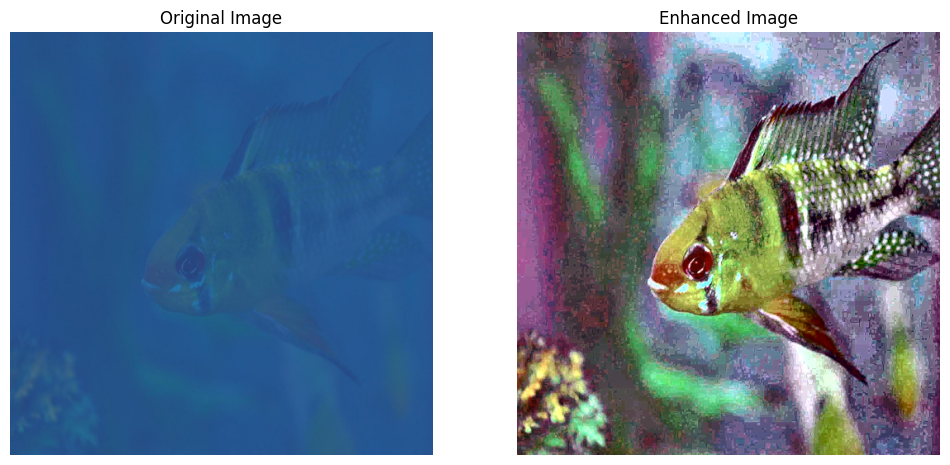

Processing '10.bmp'...
Close the image window to continue to the next image...


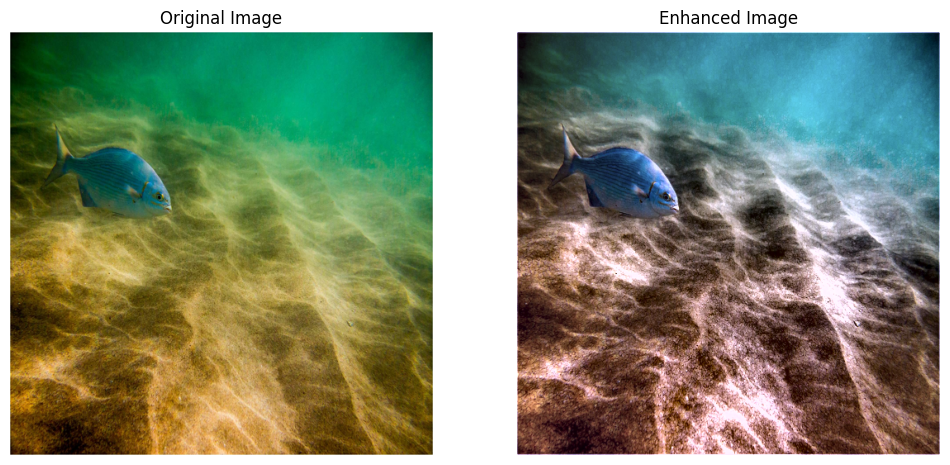

Processing '11.bmp'...
Close the image window to continue to the next image...


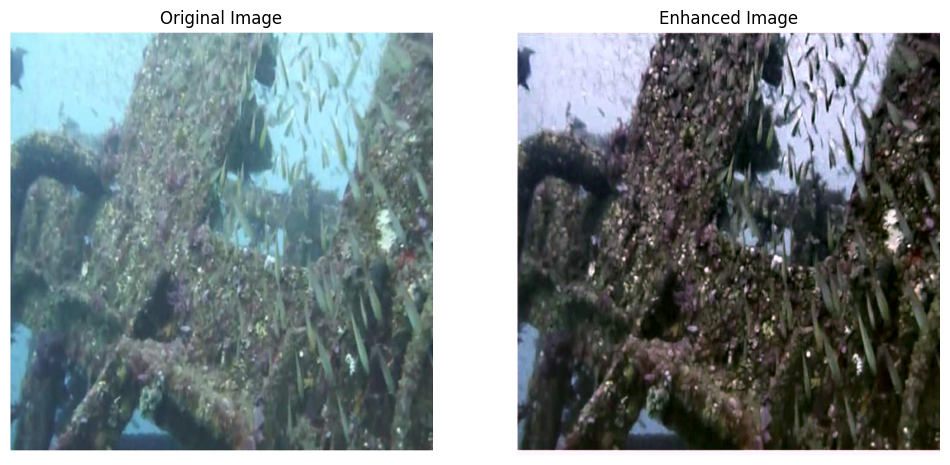

Processing '2.bmp'...
Close the image window to continue to the next image...


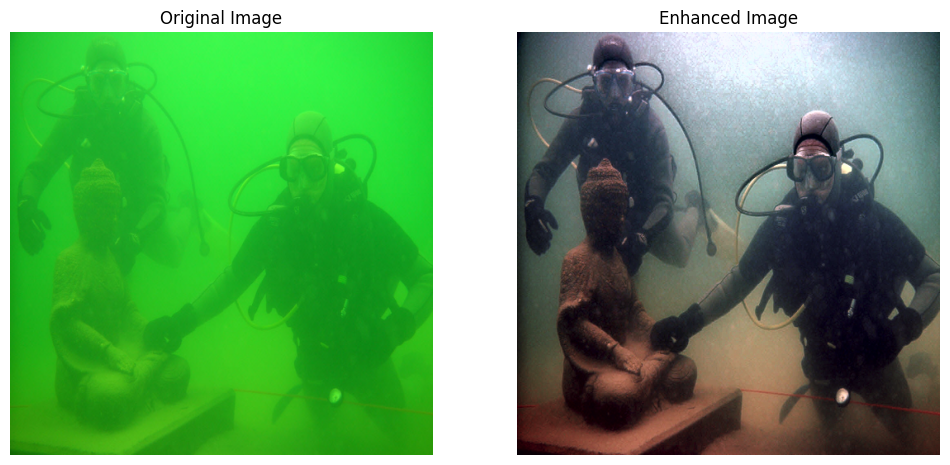

Processing '3.bmp'...
Close the image window to continue to the next image...


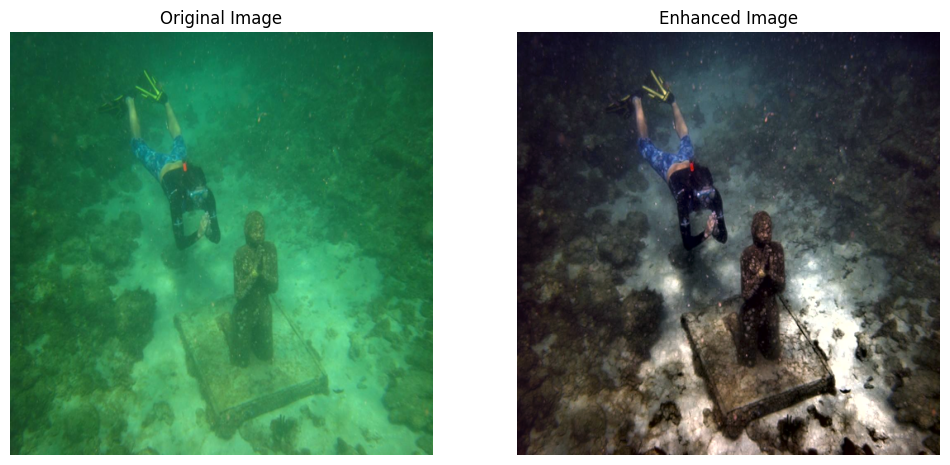

Processing '4.bmp'...
Close the image window to continue to the next image...


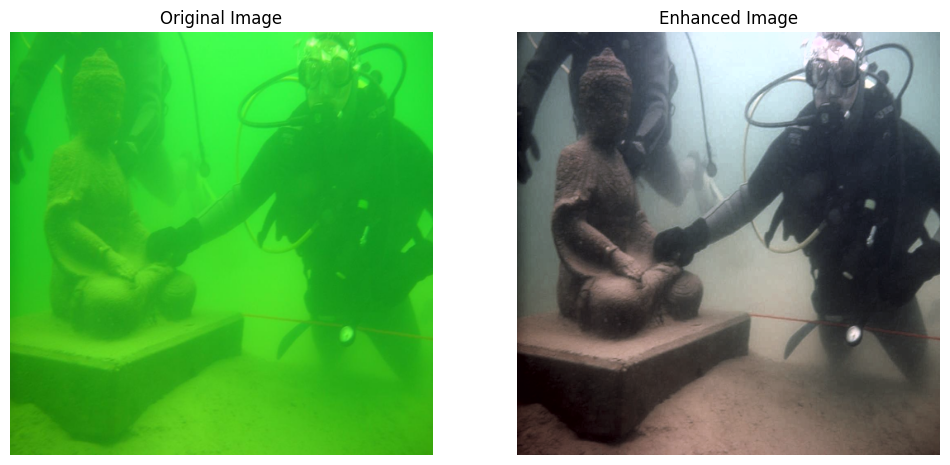

Processing '5.bmp'...
Close the image window to continue to the next image...


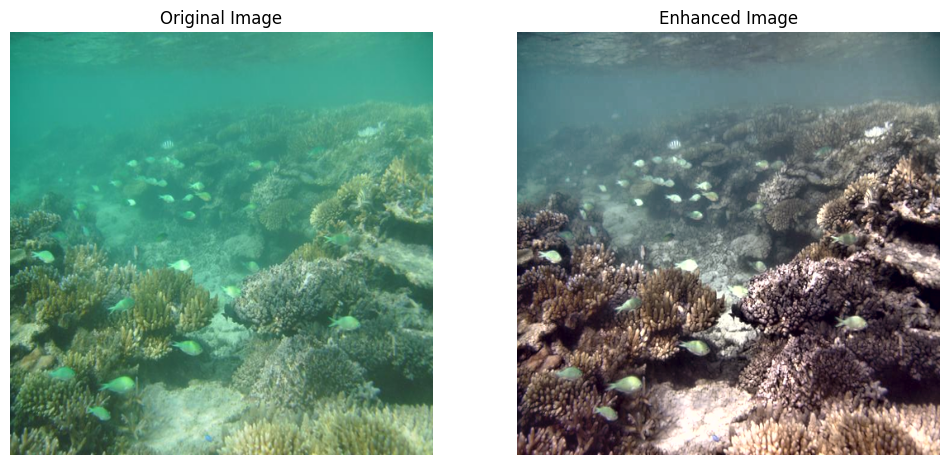

Processing '6.bmp'...
Close the image window to continue to the next image...


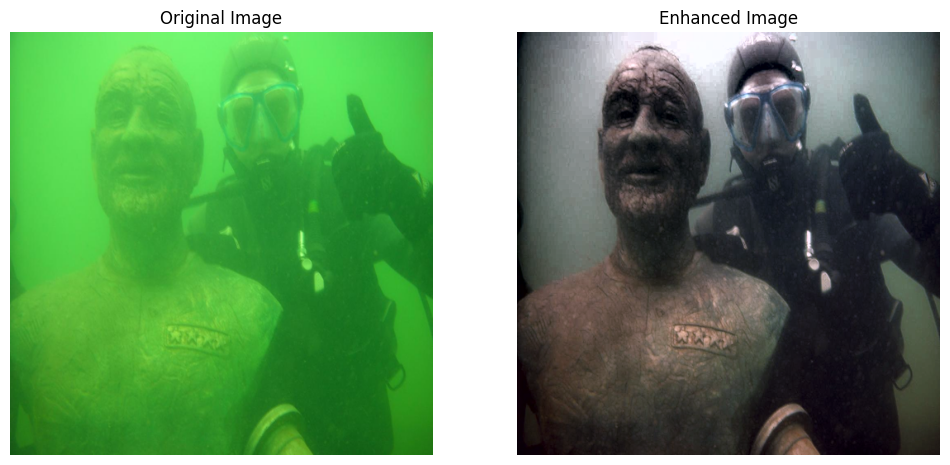

Processing '7.bmp'...
Close the image window to continue to the next image...


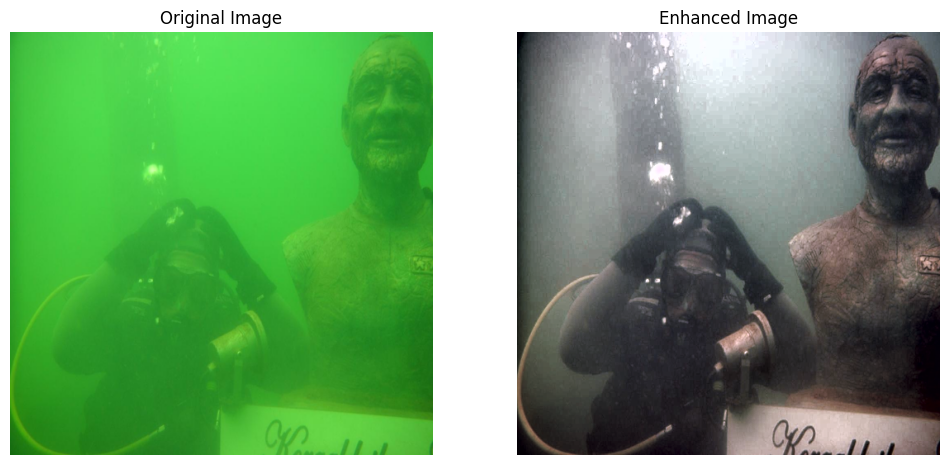

Processing '8.bmp'...
Close the image window to continue to the next image...


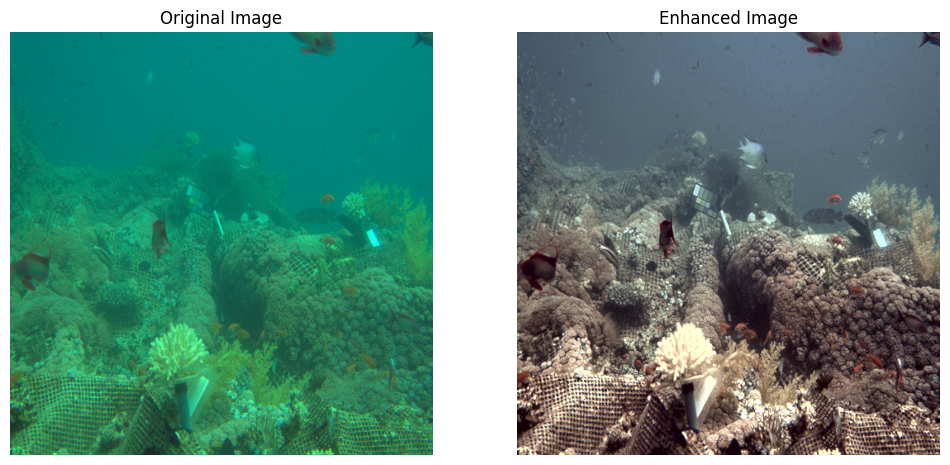

Processing '9.bmp'...
Close the image window to continue to the next image...


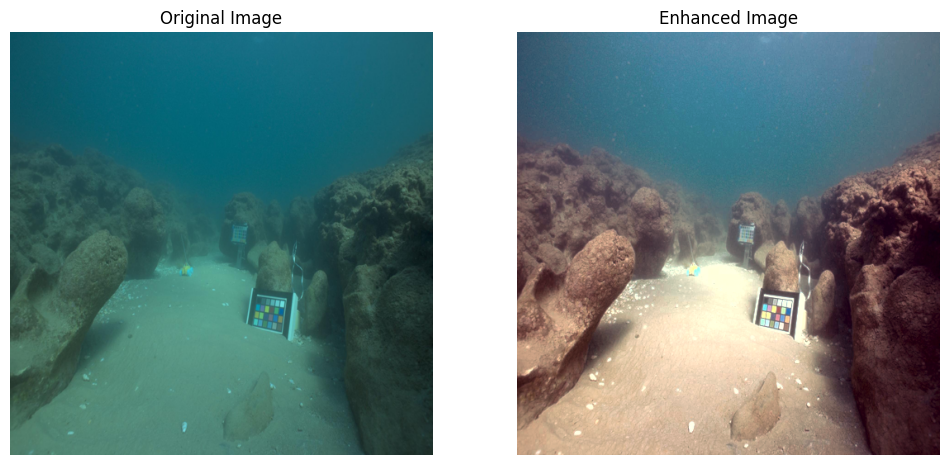

In [6]:
def main():
    """
    Main function to run the underwater image restoration process.
    """
    # Set the directory where the images are stored
    # Note: Using forward slashes is recommended for cross-platform compatibility
    images_dir = 'image/11_images'

    # Get a list of all bmp images in the directory
    # You can add other extensions like '.png', '.jpg' if needed
    supported_extensions = ('.bmp',)
    try:
        image_files = [
            f for f in os.listdir(images_dir) 
            if f.lower().endswith(supported_extensions)
        ]
    except FileNotFoundError:
        print(f"Error: Input directory not found at '{os.path.abspath(images_dir)}'")
        return

    # Loop over each image in the directory
    for filename in image_files:
        
        # Construct the full path to the input image
        input_path = os.path.join(images_dir, filename)
        
        # Read the input image
        # OpenCV reads images in BGR format by default
        Input = cv2.imread(input_path)
        
        if Input is None:
            print(f"Warning: Could not read image {filename}. Skipping.")
            continue
            
        print(f"Processing '{filename}'...")

        # Apply the underwater image restoration algorithm
        # This function is expected to take a BGR image and return a BGR image
        output = CCCBLSHL(Input)
        
        # Create a new figure to display the original and enhanced images
        plt.figure(figsize=(12, 6))
        
        # Display the original image in the first subplot
        plt.subplot(1, 2, 1)
        # Convert BGR (OpenCV) to RGB (Matplotlib) for correct color display
        plt.imshow(cv2.cvtColor(Input, cv2.COLOR_BGR2RGB))
        plt.title('Original Image')
        plt.axis('off') # Hide axes

        # Display the enhanced image in the second subplot
        plt.subplot(1, 2, 2)
        # Convert the BGR output to RGB for display
        plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
        plt.title('Enhanced Image')
        plt.axis('off') # Hide axes
        
        # In Python, plt.show() displays the figure and pauses execution
        # until the figure window is closed. This is the equivalent of 'pause'.
        print("Close the image window to continue to the next image...")
        plt.show()

main()